# Loading Libraries, Parameters, Functions

In [2]:
import uuid
import numba, cv2, gc, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tifffile as tiff 
import seaborn as sns
import rasterio
from rasterio.windows import Window
import pathlib, sys, os, random, time

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

DATA_PATH = './'
EPOCHES = 1
BATCH_SIZE = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [4]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         6 non-null      object
 1   predicted  6 non-null      object
dtypes: object(2)
memory usage: 224.0+ bytes


In [5]:
#d = d.drop(d[d.id == 'HandE_B005_CL_b_RGB_topright'])
df = df.drop(df[df.id == 'HandE_B005_CL_b_RGB_topright'].index[0])
df

,id,predicted
0,CL_HandE_1234_B004_bottomright,12972850 36 12977382 42 12981914 47 12986448 5...
1,CL_HandE_1234_B004_topleft,2023885 36 2028419 40 2032953 44 2037487 47 20...
2,CL_HandE_1234_B004_topright,372094 8 376628 12 381163 14 385698 16 390233 ...
3,HandE_B005_CL_b_RGB_bottomright,2247721 26 2252254 31 2256788 34 2261323 36 22...
4,HandE_B005_CL_b_RGB_topleft,366048 27 370578 43 375111 48 379646 52 384181...


In [6]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

In [7]:
df.iloc[1,0]

'CL_HandE_1234_B004_topleft'

 Image shape: (4536, 4704, 3)
 Mask shape: (4536, 4704)
 Resized Image shape: (226, 235, 3)
 Resized Mask shape: (226, 235)


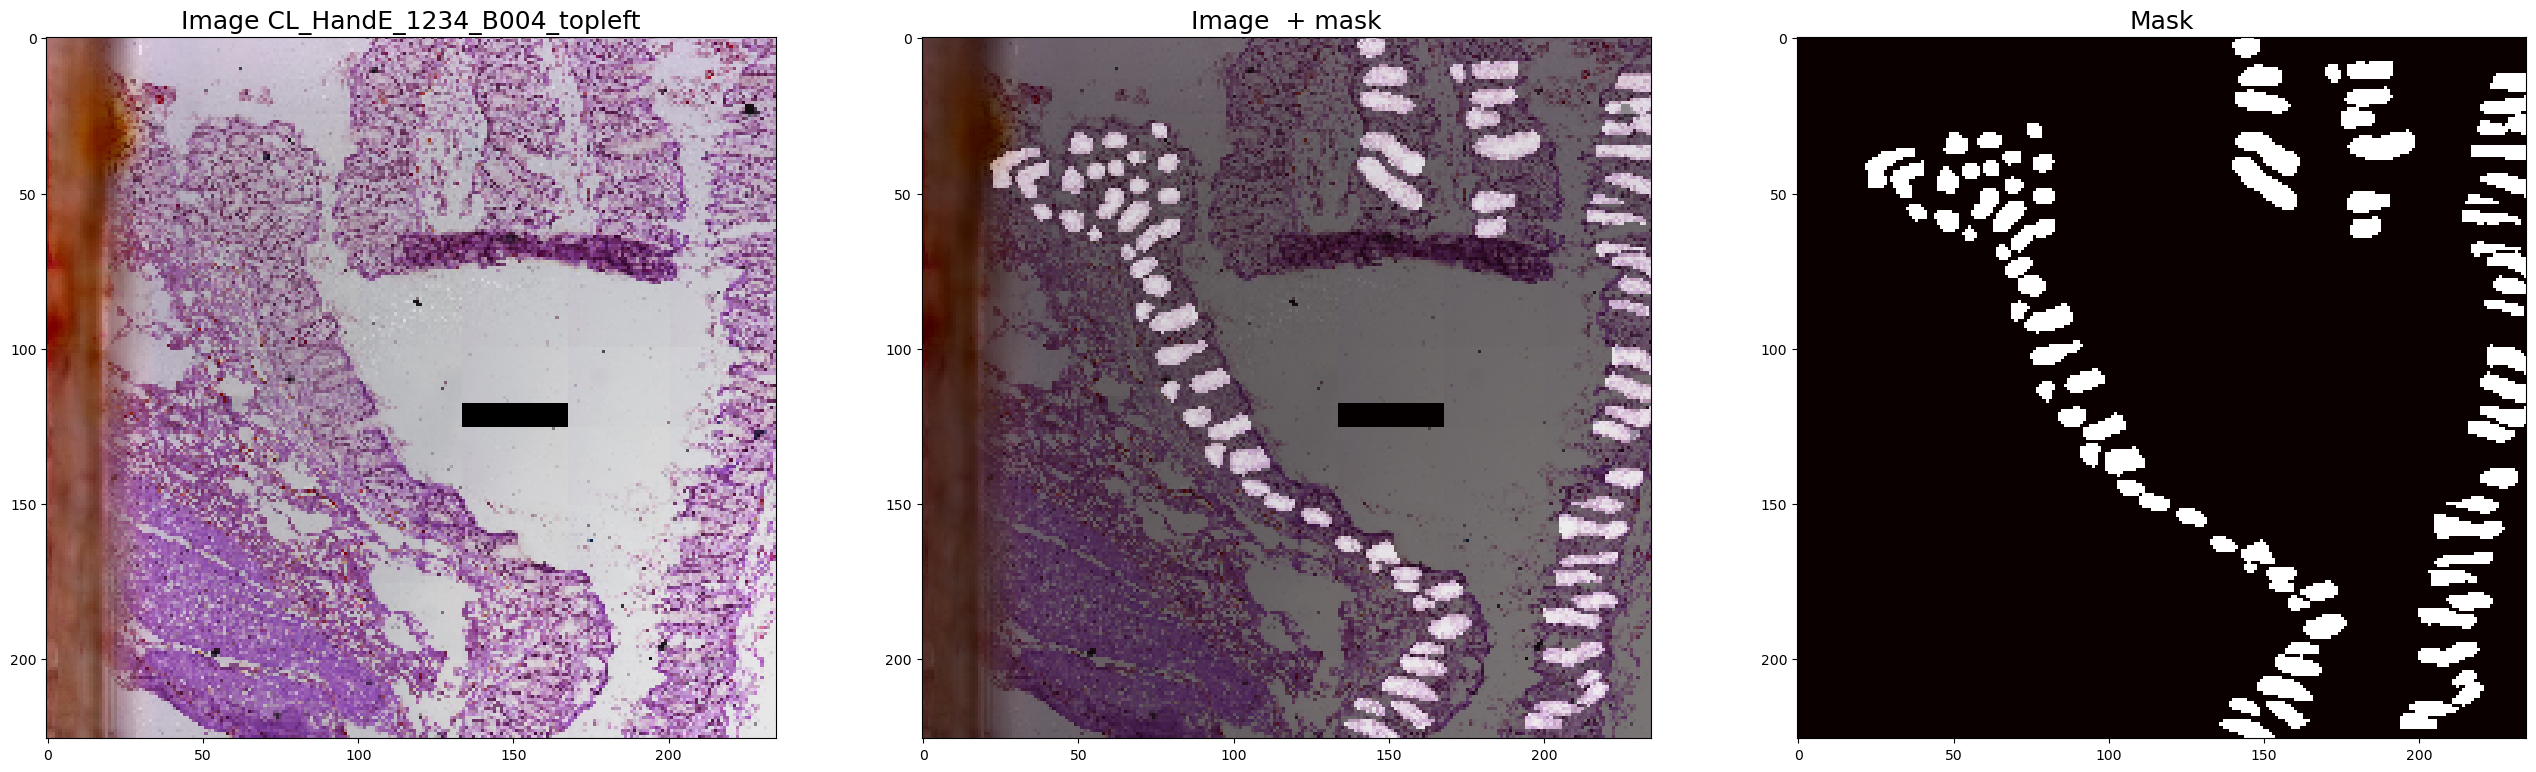

In [8]:
img_id_1 = df.iloc[1,0]
BASE_PATH = 'train/'
def plot_image(image_id, BASE_PATH = BASE_PATH, scale=None, verbose=1, df = df):
    image = tiff.imread(os.path.join(BASE_PATH, f"{image_id}.tiff"))
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle_decode(df[df["id"] == image_id]["predicted"].values[0], (image.shape[0],image.shape[1]))
    if verbose:
        print(f" Image shape: {image.shape}")
        print(f" Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f" Resized Image shape: {image.shape}")
            print(f" Resized Mask shape: {mask.shape}")
    plt.figure(figsize=(32, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title("Image  + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
            
    del image, mask

plot_image(img_id_1, BASE_PATH ,scale = 20 )

In [9]:
df

,id,predicted
0,CL_HandE_1234_B004_bottomright,12972850 36 12977382 42 12981914 47 12986448 5...
1,CL_HandE_1234_B004_topleft,2023885 36 2028419 40 2032953 44 2037487 47 20...
2,CL_HandE_1234_B004_topright,372094 8 376628 12 381163 14 385698 16 390233 ...
3,HandE_B005_CL_b_RGB_bottomright,2247721 26 2252254 31 2256788 34 2261323 36 22...
4,HandE_B005_CL_b_RGB_topleft,366048 27 370578 43 375111 48 379646 52 384181...


Plots for : CL_HandE_1234_B004_bottomright
 Image shape: (4536, 4704, 3)
 Mask shape: (4536, 4704)
 Resized Image shape: (226, 235, 3)
 Resized Mask shape: (226, 235)


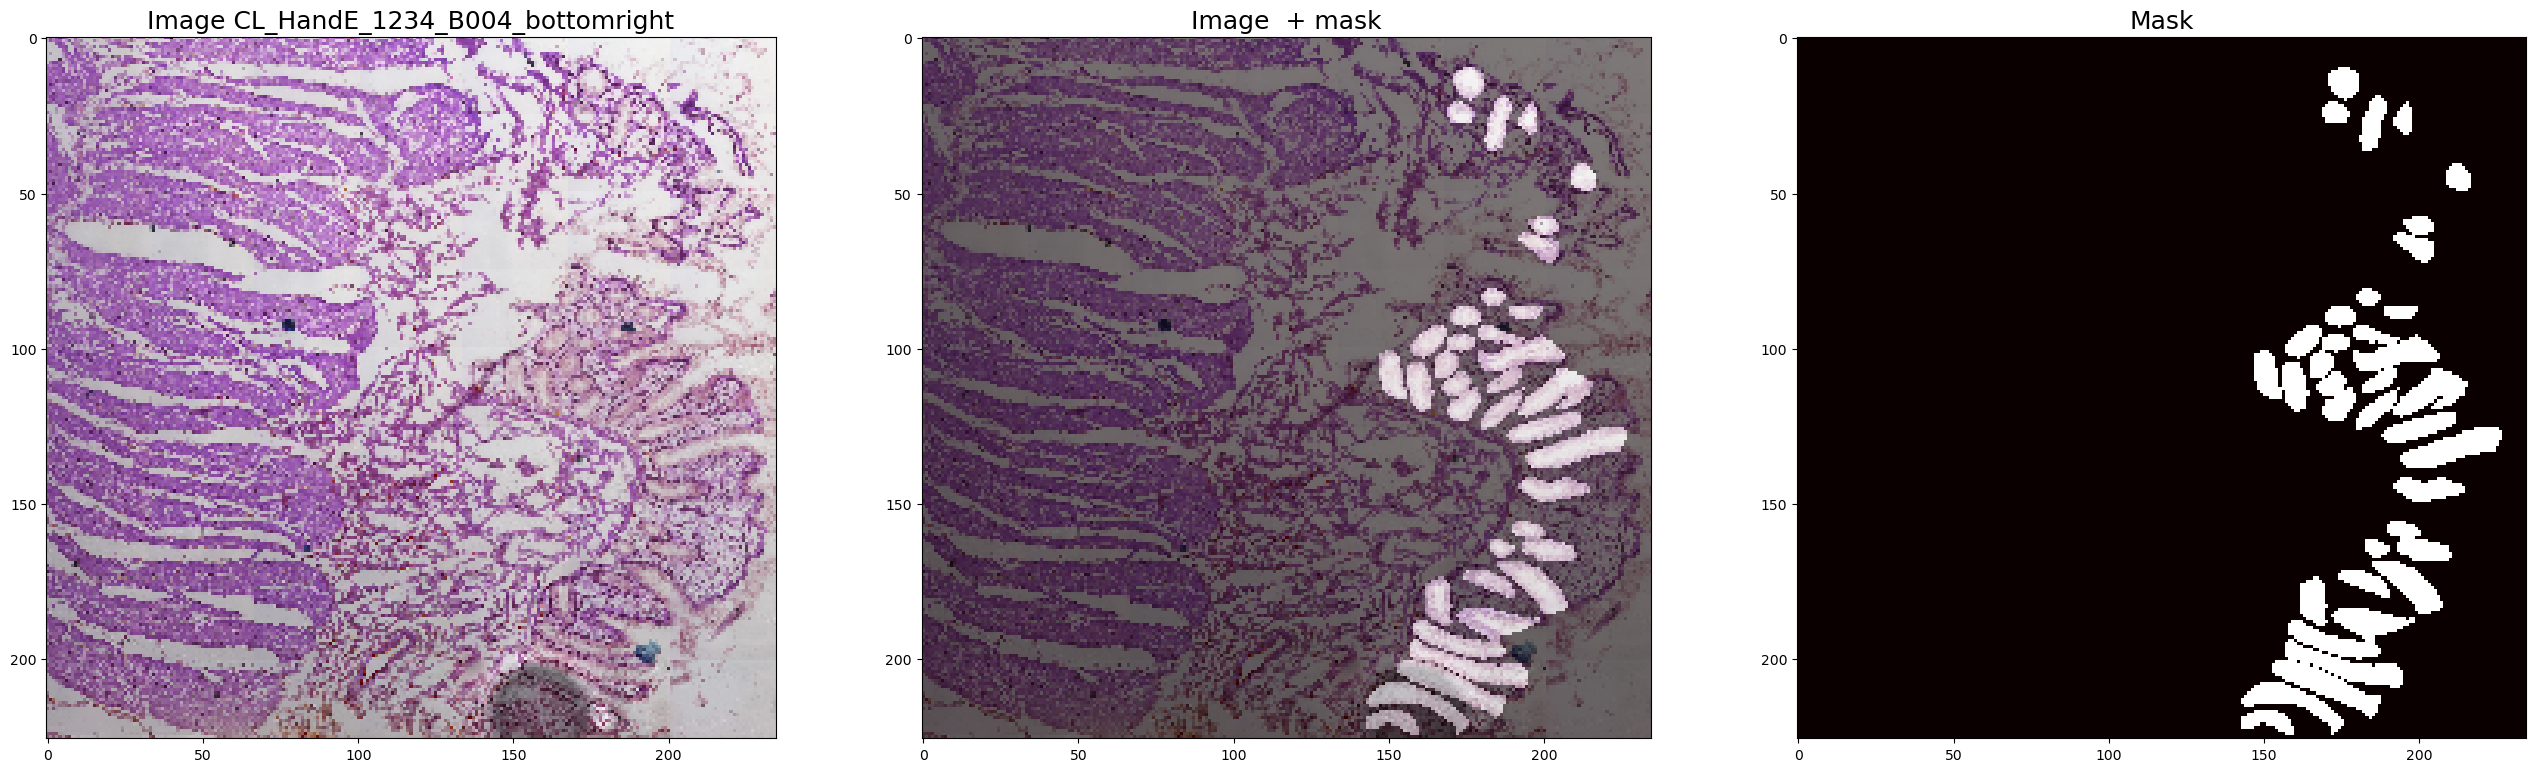

Plots for : CL_HandE_1234_B004_topleft
 Image shape: (4536, 4704, 3)
 Mask shape: (4536, 4704)
 Resized Image shape: (226, 235, 3)
 Resized Mask shape: (226, 235)


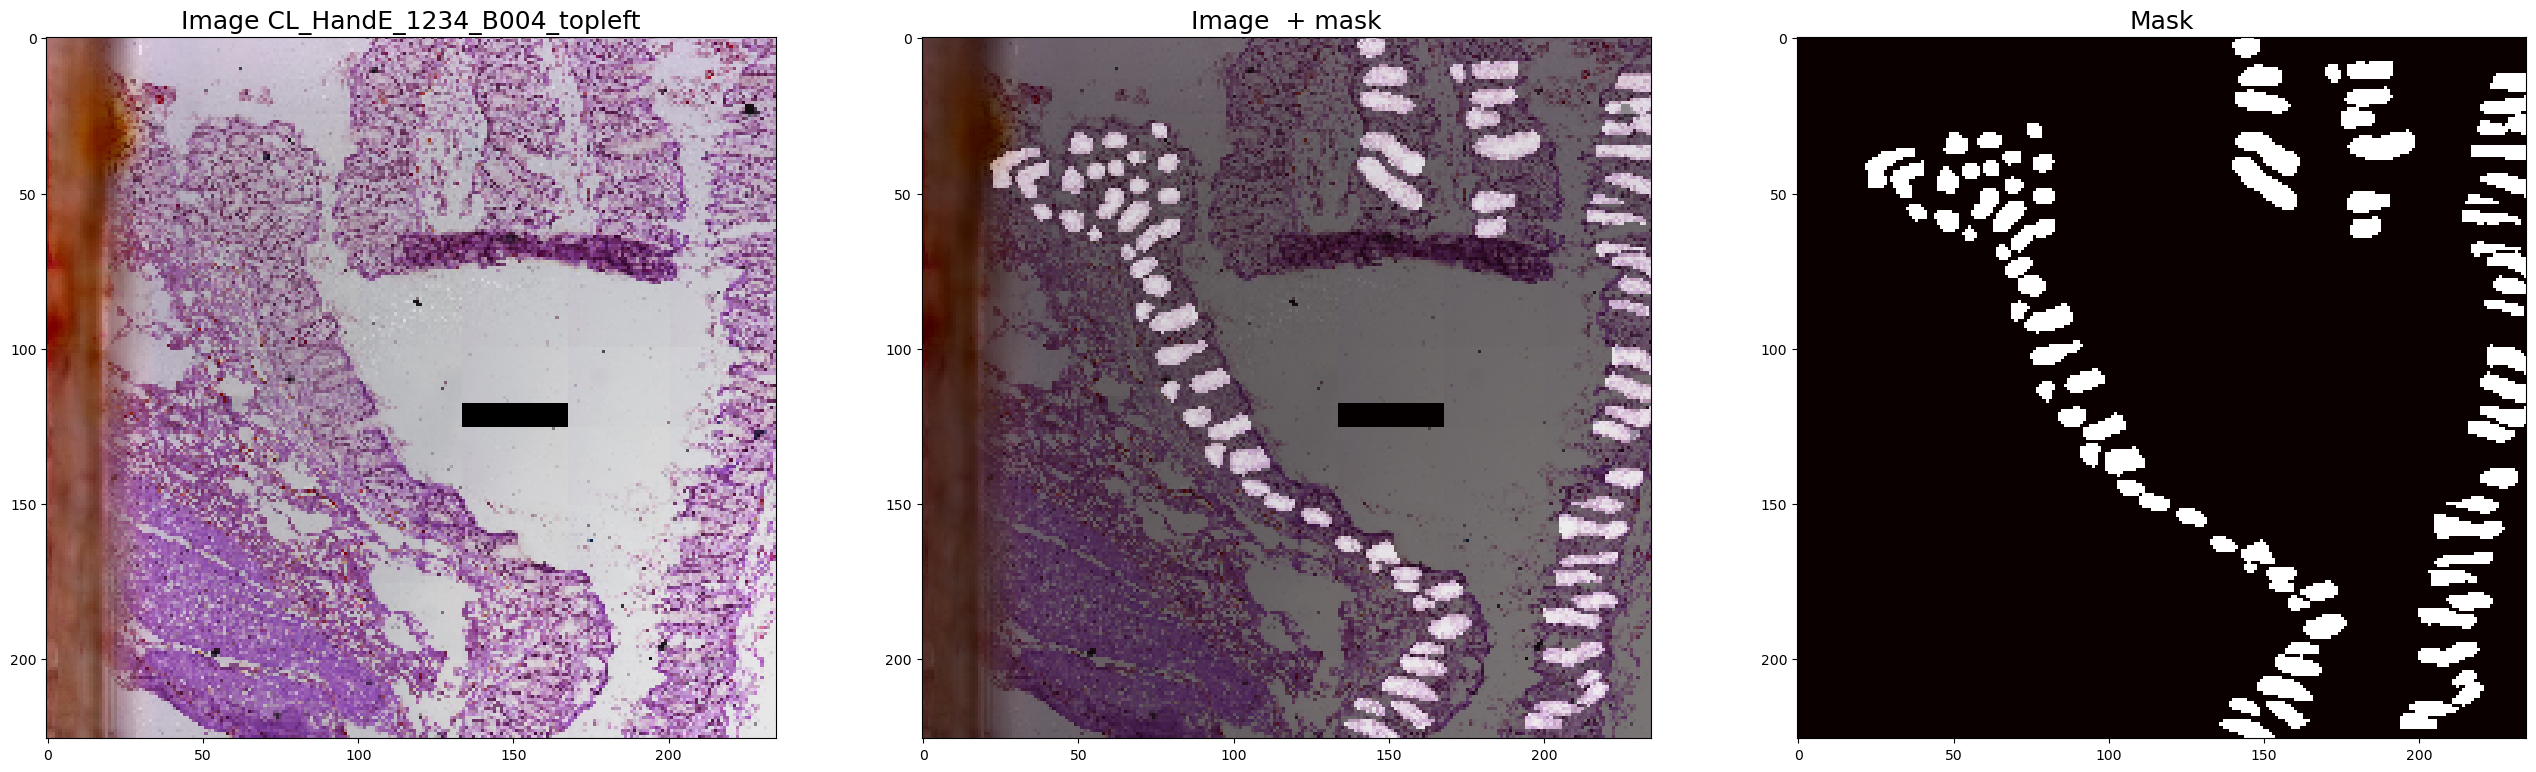

Plots for : CL_HandE_1234_B004_topright
 Image shape: (4536, 4704, 3)
 Mask shape: (4536, 4704)
 Resized Image shape: (226, 235, 3)
 Resized Mask shape: (226, 235)


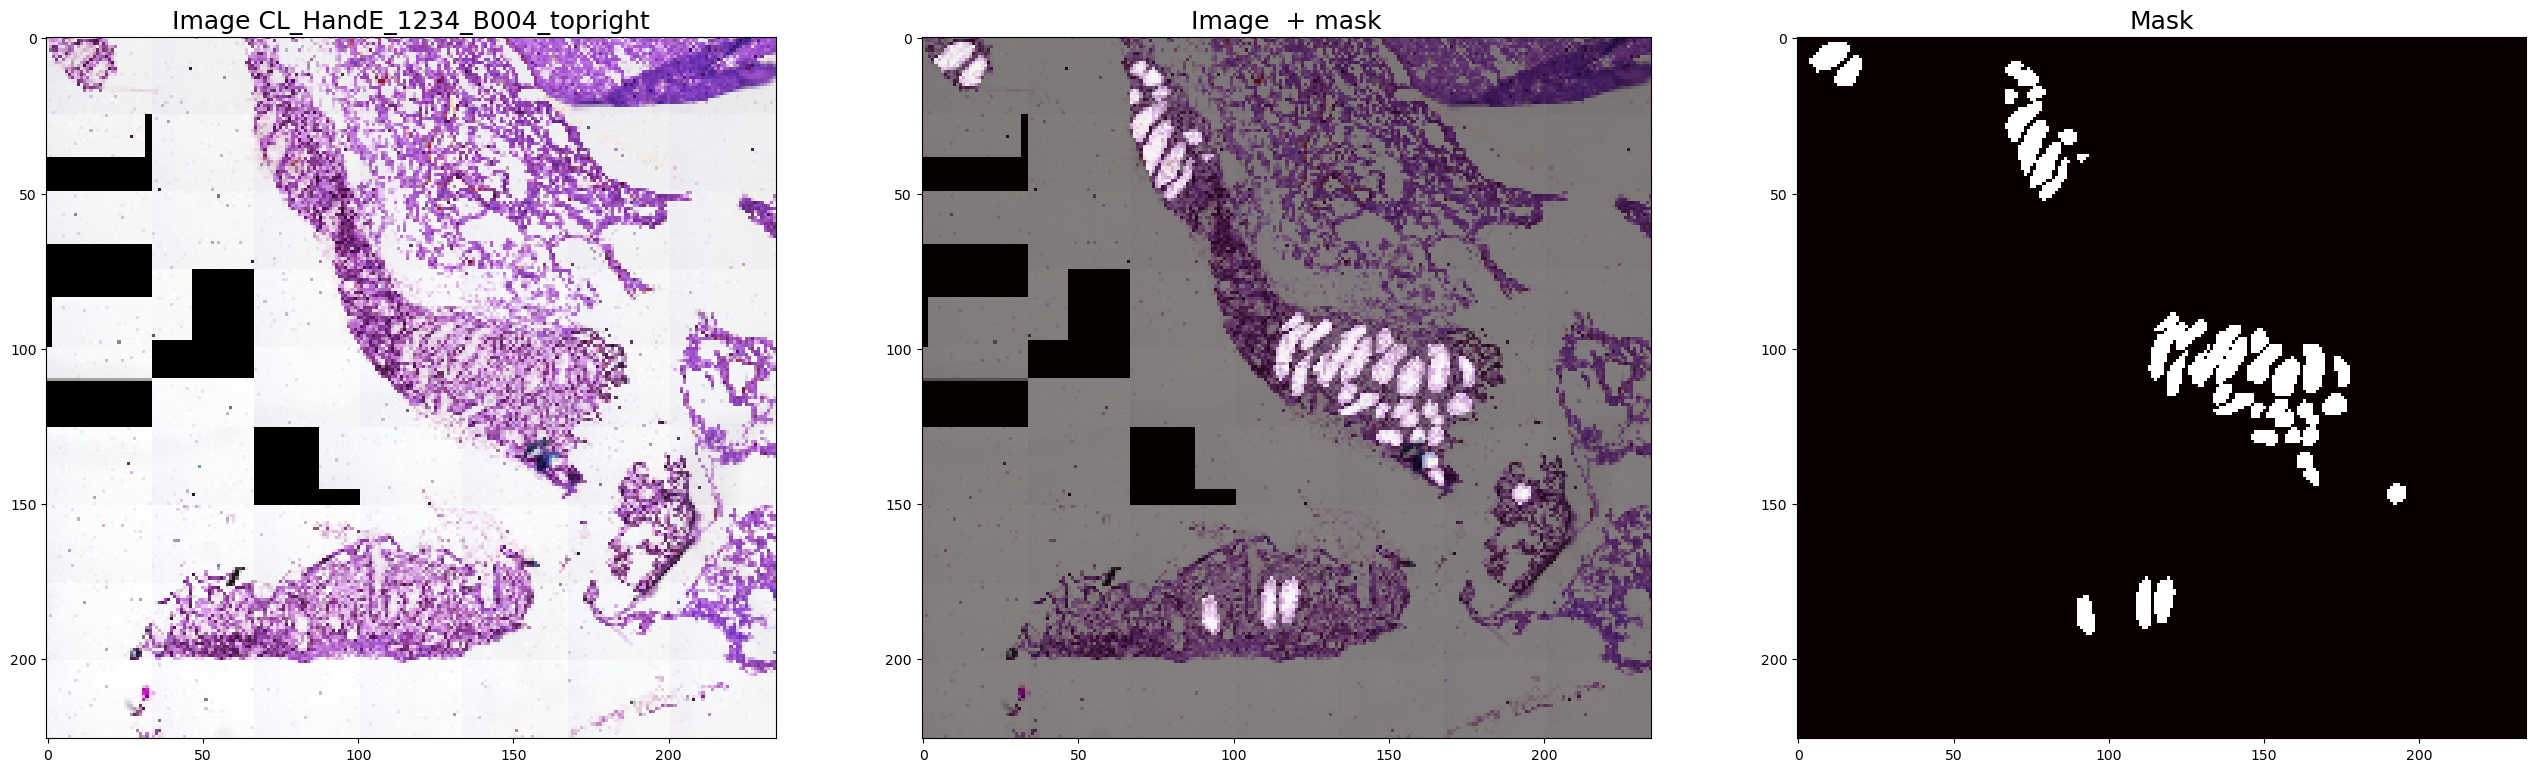

Plots for : HandE_B005_CL_b_RGB_bottomright
 Image shape: (4536, 4704, 3)
 Mask shape: (4536, 4704)
 Resized Image shape: (226, 235, 3)
 Resized Mask shape: (226, 235)


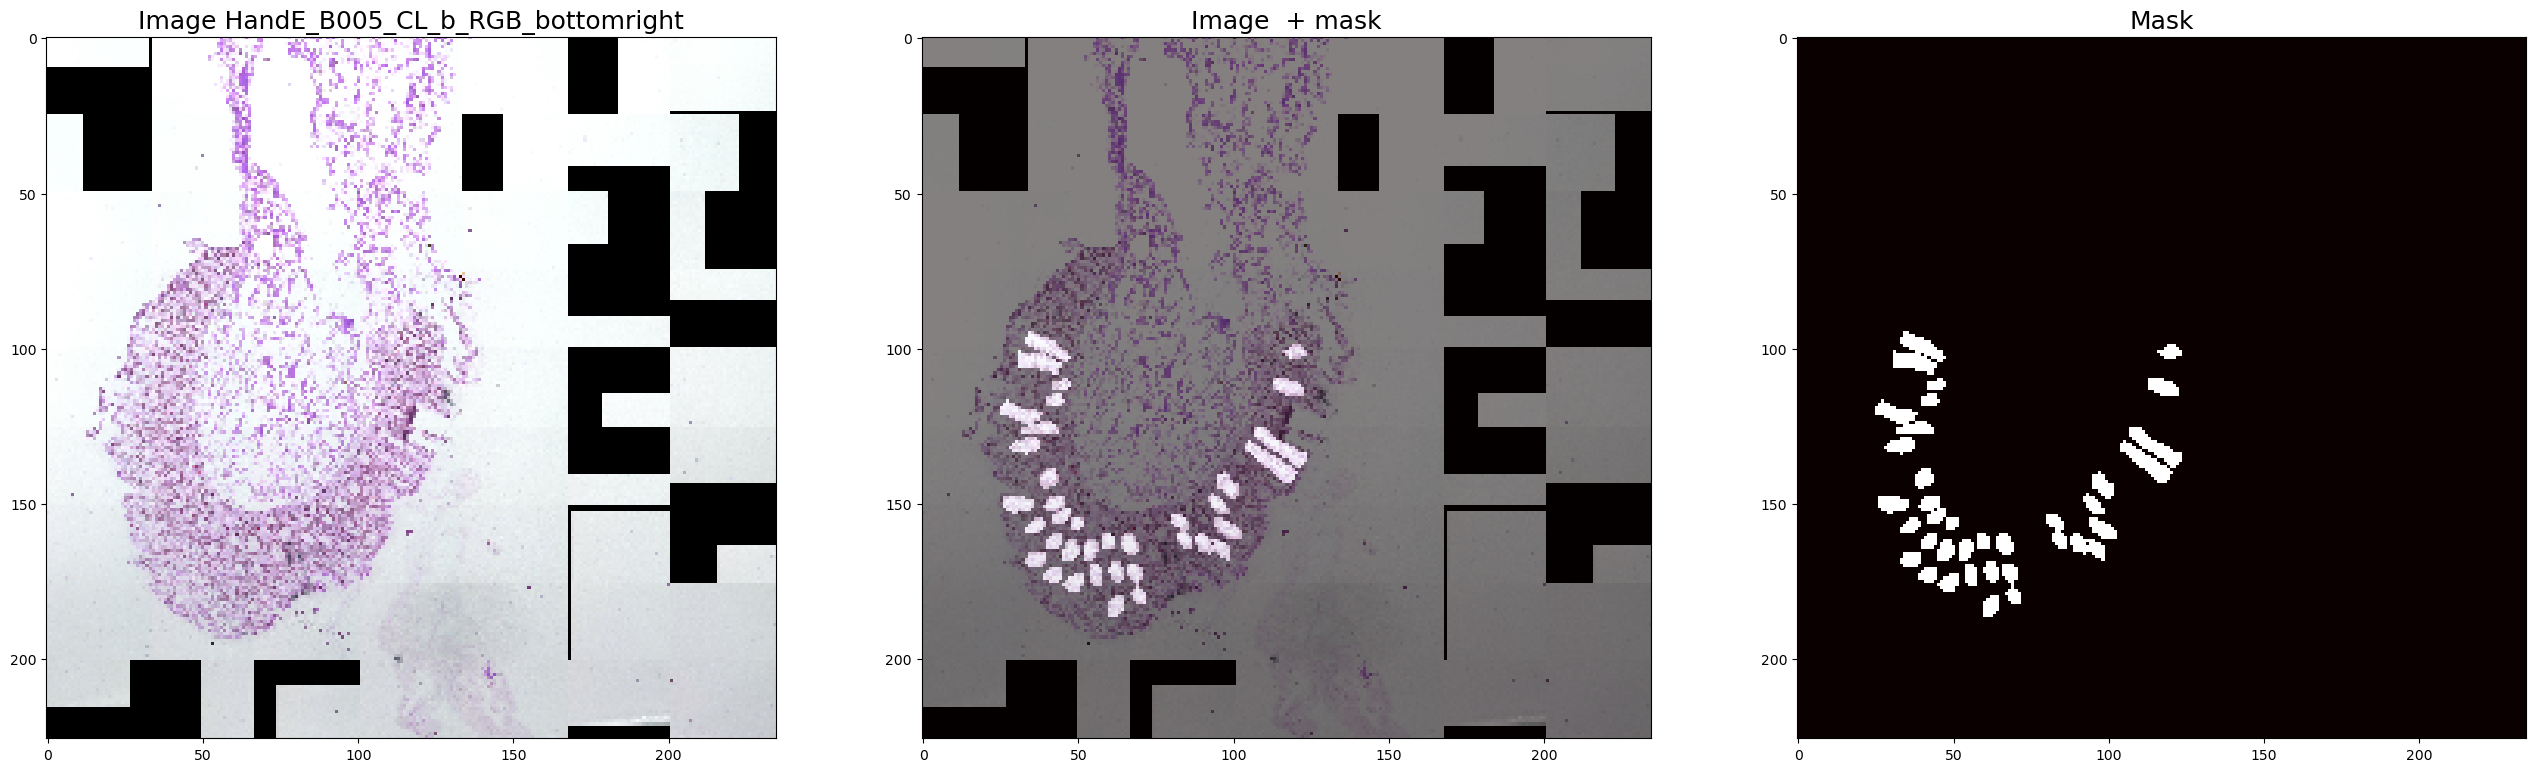

Plots for : HandE_B005_CL_b_RGB_topleft
 Image shape: (4536, 4704, 3)
 Mask shape: (4536, 4704)
 Resized Image shape: (226, 235, 3)
 Resized Mask shape: (226, 235)


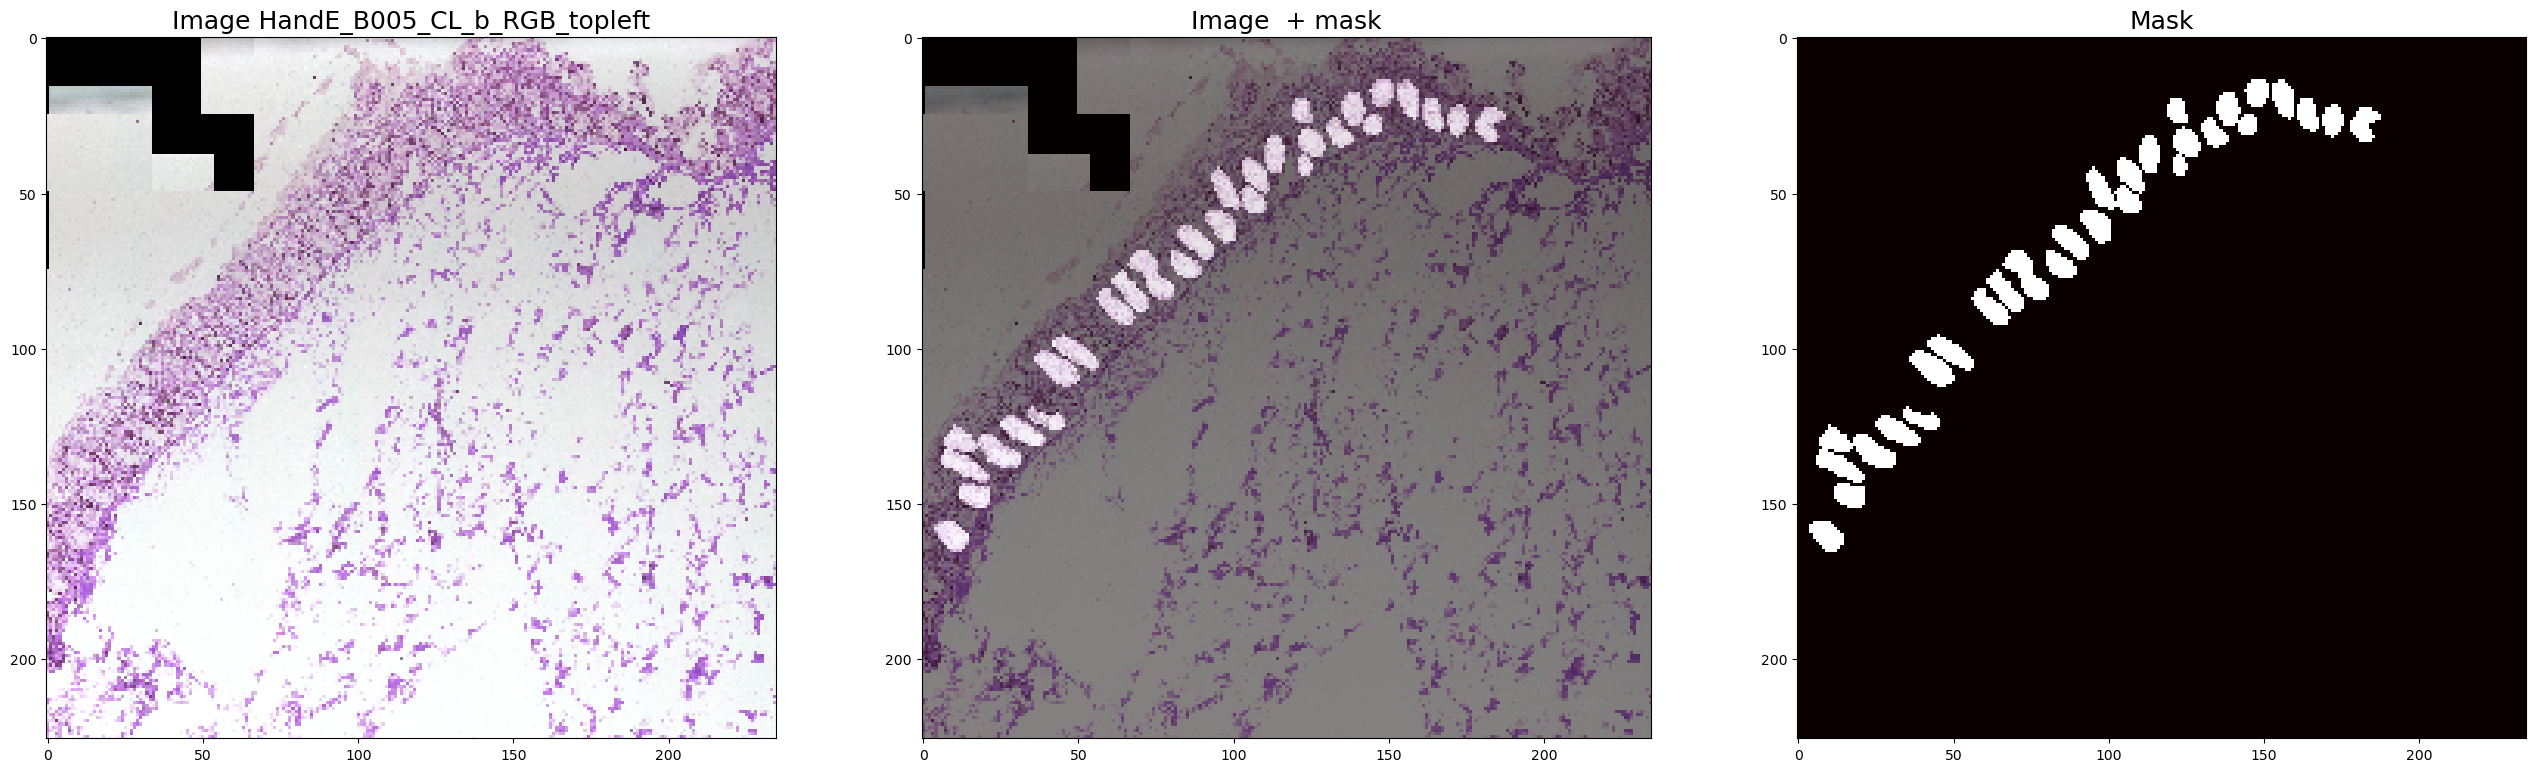

In [10]:
#img_id_1 = df.iloc[1,0]
BASE_PATH = 'train/'
for i in range(len(df['id'])):
    print("Plots for :",df.iloc[i,0])
    plot_image(df.iloc[i,0], BASE_PATH ,scale = 20)

In [12]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class ColonDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=0, threshold = 100):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        #self.csv = pd.read_csv((self.path / 'train.csv').as_posix())
        d = pd.read_csv('train.csv')
        d = d.drop(d[d.id == 'HandE_B005_CL_b_RGB_topright'].index[0])
        d = d.set_index('id')
        self.csv = d
        self.threshold = threshold
    
        self.ids = {}
        self.x, self.y = [], []
        self.build_slices()
        self.len = len(self.x)
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        count = 0
        for i, filename in enumerate(self.csv.index.values):
            tmp = []
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            print(f'Transform-{filename}')
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'predicted'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window, min_overlap=self.overlap)
                
                for slc in tqdm(slices, leave=False):
                    x1,x2,y1,y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold or np.random.randint(100) > 120:
                        self.slices.append([i,x1,x2,y1,y2])
                        
                        image = dataset.read([1,2,3],
                            window=Window.from_slices((x1,x2),(y1,y2)))
                        
                        image = np.moveaxis(image, 0, -1)
                        self.x.append(image)
                        self.y.append(self.masks[-1][x1:x2,y1:y2])
                        tmp.append(count)
                        count += 1
            self.ids[i] = tmp
        with open("folds.pkl", "wb") as f:
            pickle.dump(self.ids, f)
    
    # get data operation
    def __getitem__(self, index):
        img, mask = self.x[index], self.y[index]
        if self.transform is not None:
            augmented = self.transform(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)#self.as_tensor(img), mask
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [13]:
import albumentations as A

WINDOW = 256
MIN_OVERLAP = 32
#NEW_SIZE = 512

trfm = A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=1.)

gc.collect()
ds = ColonDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)


Transform-CL_HandE_1234_B004_bottomright


  0%|          | 0/462 [00:00<?, ?it/s]

Transform-CL_HandE_1234_B004_topleft


  0%|          | 0/462 [00:00<?, ?it/s]

Transform-CL_HandE_1234_B004_topright


  0%|          | 0/462 [00:00<?, ?it/s]

Transform-HandE_B005_CL_b_RGB_bottomright


  0%|          | 0/462 [00:00<?, ?it/s]

Transform-HandE_B005_CL_b_RGB_topleft


  0%|          | 0/462 [00:00<?, ?it/s]

torch.Size([2, 3, 256, 256])


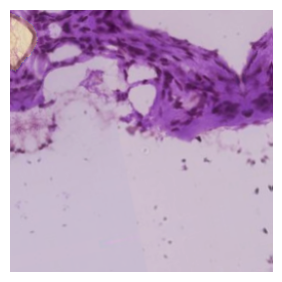

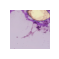

4242

In [14]:
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

d_train = D.DataLoader(ds,batch_size=2,shuffle=False,num_workers=0)
imgs,masks = next(iter(d_train))
print(imgs.shape)
plt.figure(figsize=(32,32))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()
    
del imgs,masks
gc.collect()

# Test Visualization

In [15]:
test = pd.read_csv('test.csv')
test

,id,predicted
0,CL_HandE_1234_B004_bottomleft,398887 19 403421 23 407956 25 412488 30 417022...
1,HandE_B005_CL_b_RGB_bottomleft,13716716 23 13721248 29 13725782 32 13730316 3...


In [25]:
#img_id_1 = df.iloc[1,0]
BASE_PATH_test = './test/'
mask_path = './test_mask/'
def plot_image_test(image_id, BASE_PATH = BASE_PATH_test, scale=None, verbose=1, df = test,mask_path = mask_path):
    image = tiff.imread(os.path.join(BASE_PATH, f"{image_id}.tiff")) #test_image
    #test_mask = tiff.imread(os.path.join(mask_path, f"{image_id}.tiff")) #given mask
    
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    #mask - actual
    mask = rle_decode(df[df["id"] == image_id]["predicted"].values[0], (image.shape[0],image.shape[1]))
    #mask - predicted
    output_val = pd.read_csv('submission_output_file.csv')
    mask_out = rle_decode(output_val[output_val["id"] == image_id]["predicted"].values[0], (image.shape[0],image.shape[1]))

    if verbose:
        print("",end = "")
        #print(f" Image shape: {image.shape}")
        #print(f" Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print("",end = "")
            #print(f" Resized Image shape: {image.shape}")
            #print(f" Resized Mask shape: {mask.shape}")
    plt.figure(figsize=(32, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    #plt.imshow(mask_out, cmap="hot", alpha=0.5)
    plt.title("Image ", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Actual Mask - Values given", fontsize=18)   
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask_out, cmap="hot")
    plt.title(f"Predicted - Output", fontsize=18)    
    
    plt.show()
            
    del image, mask

Plots for : CL_HandE_1234_B004_bottomleft


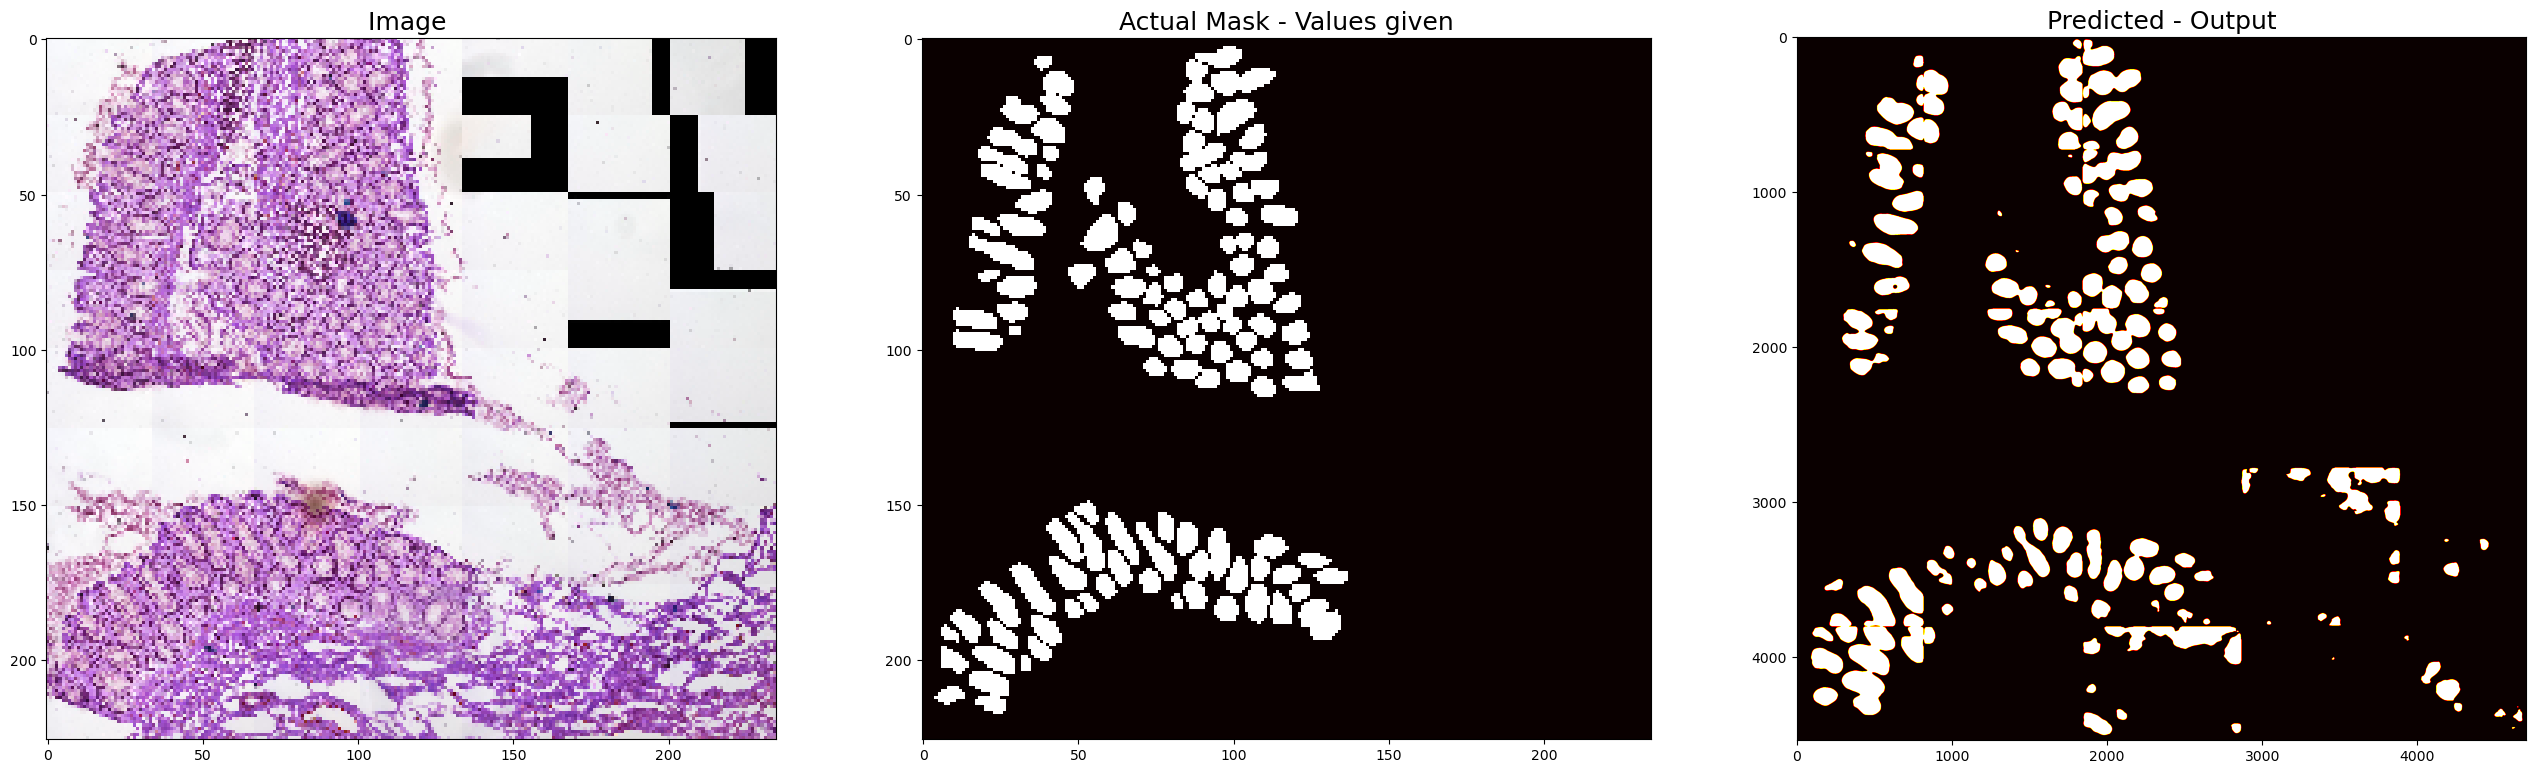

Plots for : HandE_B005_CL_b_RGB_bottomleft


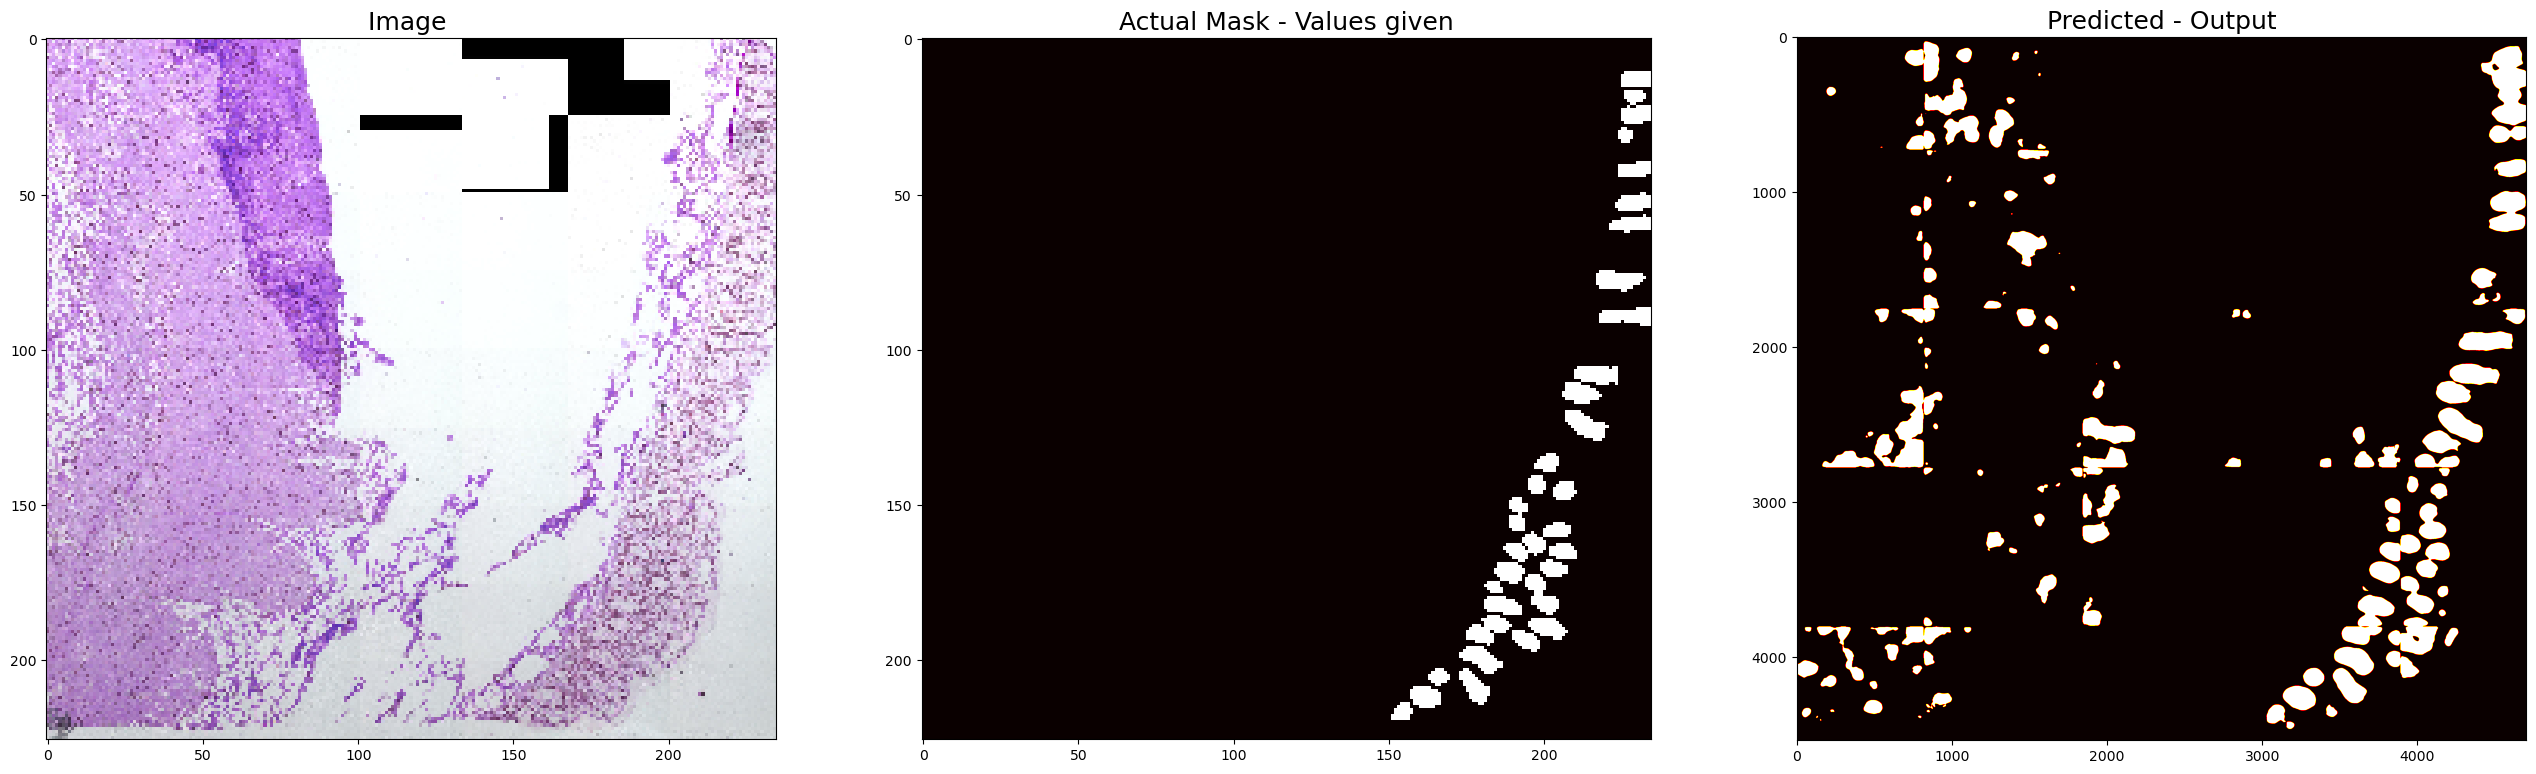

In [26]:
#img_id_1 = df.iloc[1,0]
#BASE_PATH = 'train/'
df_test = pd.read_csv('test.csv')
for i in range(len(df_test['id'])):
    print("Plots for :",df_test.iloc[i,0])
    plot_image_test(df_test.iloc[i,0], BASE_PATH_test ,scale = 20)

# Visualization ends here. Thank you!